In [3]:
import json

import matplotlib.pyplot as plt
from numpy import average
from pandas import DataFrame, json_normalize, read_csv


In [27]:
def read_log_file(filepath) -> DataFrame:
    with open(filepath, "r") as f:
        lines = f.readlines()
    return json_normalize([json.loads(line) for line in lines])

In [40]:
test = read_csv("../data/PAMAP2/y_train_data.csv")
x_label = [f"{num[0]}" for num in test.value_counts().index.sort_values().to_list()][1:]

df_grid = read_log_file("../reports/logs_normal.log")
new_avgs = [
    average(df_grid["target"][idx : idx + 4]) for idx in range(0, df_grid.shape[0], 4)
]
results_grid = [
    average(new_avgs[idx : idx + 30]) for idx in range(0, len(new_avgs), 30)
]

df_bayesian = read_log_file("../reports/logs_bayesian.log")
results_bayesian = [df_bayesian["target"][:30].max()]
for idx in range(30, 80, 5):
    results_bayesian.append(df_bayesian["target"][idx : idx + 5].max())

df_rand = read_log_file("../reports/logs_normal_rand.log")
rand_avgs = [
    average(df_rand["target"][idx : idx + 4]) for idx in range(0, df_rand.shape[0], 4)
]
results_rand = [
    average(rand_avgs[idx : idx + 11]) for idx in range(0, len(rand_avgs), 11)
]

In [67]:
results_rand[10]

np.float64(0.3660861583642744)

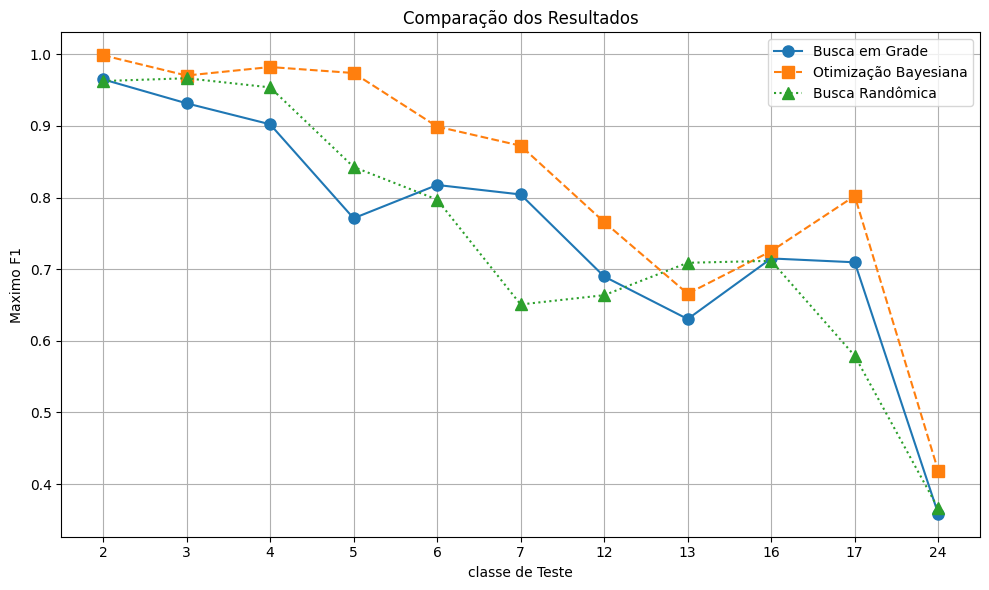

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(
    x_label,
    results_grid,
    marker="o",
    linestyle="-",
    markersize=8,
    label="Busca em Grade",
)
plt.plot(
    x_label,
    results_bayesian,
    marker="s",
    linestyle="--",
    markersize=8,
    label="Otimização Bayesiana",
)
plt.plot(
    x_label,
    results_rand,
    marker="^",
    linestyle=":",
    markersize=8,
    label="Busca Randômica",
)

plt.xlabel("classe de Teste")
plt.ylabel("Maximo F1")
plt.title("Comparação dos Resultados")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
data = {
    "Grid & Random Search": {
        "0.2": {
            "f1": 0.9591558883594282,
            "mcc": 0.692234795735105,
            "acc": 0.9276672694394213,
            "pr_auc": 0.960758665794637,
            "roc_auc": 0.76,
        },
        "0.4": {
            "f1": 0.921289095394248,
            "mcc": 0.6654563544100663,
            "acc": 0.8738838842811223,
            "pr_auc": 0.9270324381911025,
            "roc_auc": 0.7592497197054635,
        },
        "0.75": {
            "f1": 0.8612190276858107,
            "mcc": 0.6244699712132372,
            "acc": 0.8064788987034455,
            "pr_auc": 0.8781319887772944,
            "roc_auc": 0.7578218429813504,
        },
        "0.9": {
            "f1": 0.8377045414622941,
            "mcc": 0.6090816329702567,
            "acc": 0.7845521892769377,
            "pr_auc": 0.8603664349322235,
            "roc_auc": 0.7573633388549957,
        },
    },
    "Bayesian Optimization": {
        "0.2": {
            "f1": 0.9359467135052523,
            "mcc": 0.7161845231110786,
            "acc": 0.897419036659543,
            "pr_auc": 0.9893265461300753,
            "roc_auc": 0.9321560315719294,
        },
        "0.4": {
            "f1": 0.9344546044615507,
            "mcc": 0.800453878476828,
            "acc": 0.9086312948926545,
            "pr_auc": 0.981100133783426,
            "roc_auc": 0.9324441761919731,
        },
        "0.75": {
            "f1": 0.9318389571161718,
            "mcc": 0.8497711328403695,
            "acc": 0.9224843741928819,
            "pr_auc": 0.9700660281782861,
            "roc_auc": 0.9325544313556681,
        },
        "0.9": {
            "f1": 0.9307186725568366,
            "mcc": 0.8596970792064911,
            "acc": 0.9269523519106472,
            "pr_auc": 0.9661989062093939,
            "roc_auc": 0.9325705223240631,
        },
    },
}

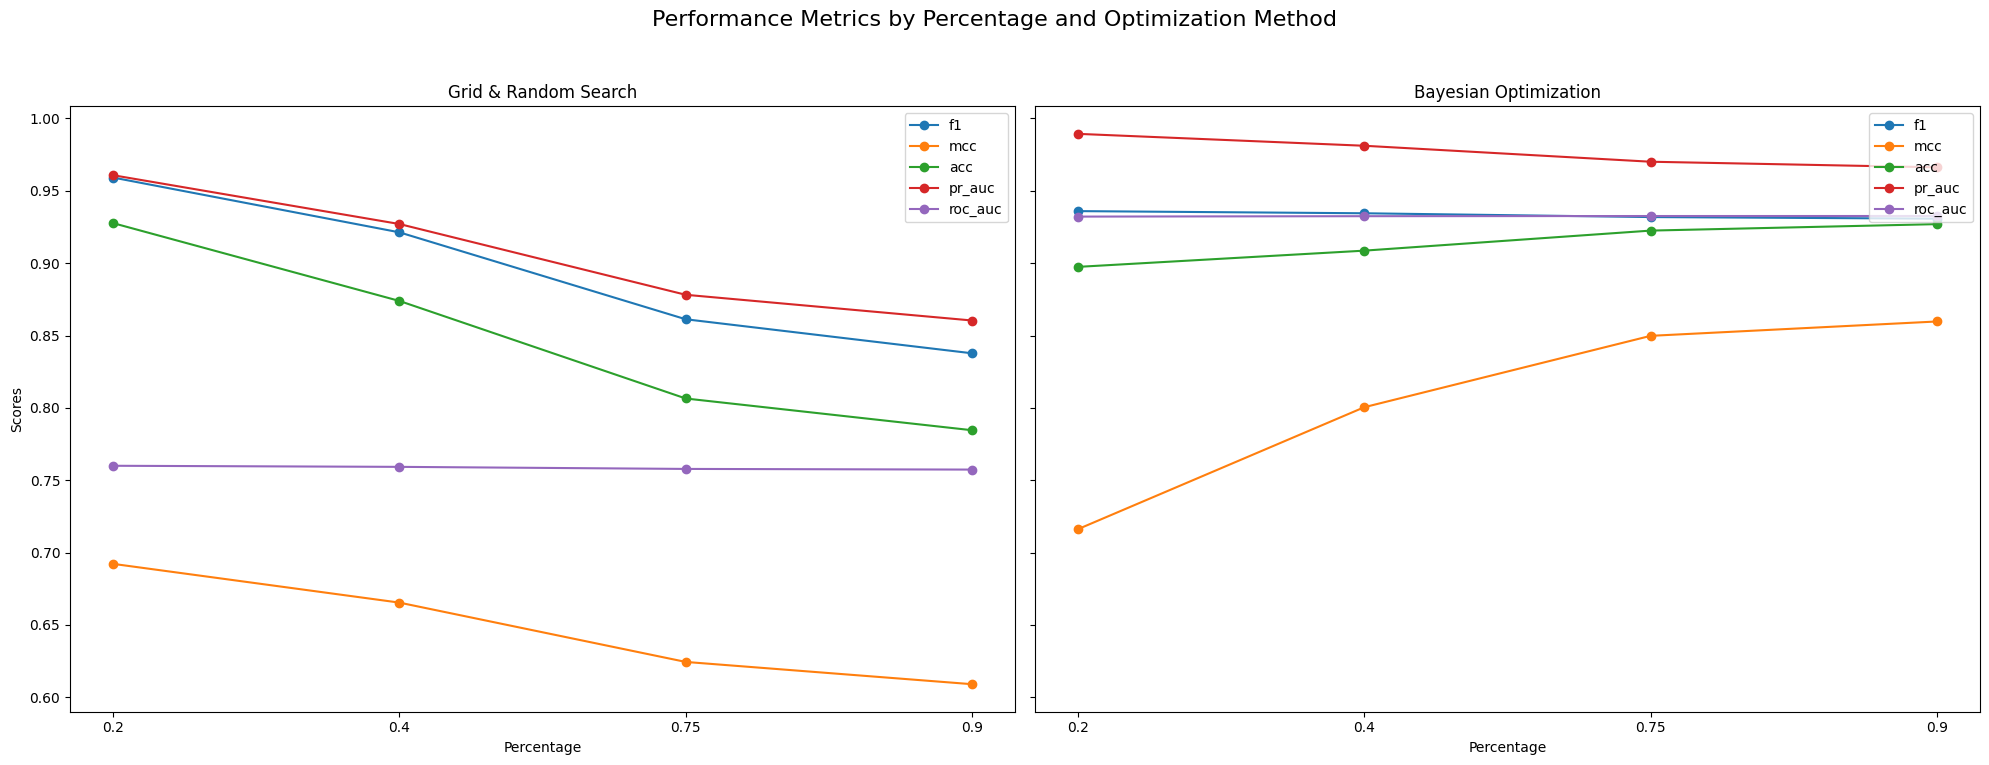

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

for i, technique in enumerate(list(data.keys())):
    for metric in list(data["Grid & Random Search"]["0.2"].keys()):
        axes[i].plot(
            percentages := list(data["Grid & Random Search"].keys()),
            [data[technique][p][metric] for p in percentages],
            marker="o",
            label=metric,
        )
    axes[i].set_ylabel("Scores" if i == 0 else "")
    axes[i].set_xlabel("Percentage")  # Label x-axis as Percentage
    axes[i].set_title(technique)
    axes[i].tick_params(axis="x", rotation=0)
    axes[i].legend(loc="upper right")

fig.suptitle("Performance Metrics by Percentage and Optimization Method", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()